<a href="https://colab.research.google.com/github/LBainWx/NWS_Projects/blob/master/QuickPlotENTLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import needed libraries
#Quickly Plot ENTLN Data

## Library Import
print(f"Importing Needed Libraries")
import sys
import numpy as np
import pandas as pd
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pytz

import requests
import zipfile
import io

import os
import re

from google.colab import drive
drive.mount('/content/drive')

!pip install cartopy
import cartopy

import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
print(f"Finished Importing Needed Libraries")

Importing Needed Libraries
Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 83.2 MB/s eta 0:00:00
Finished Importing Needed Libraries


In [17]:
#@title Import csv file of lightning data
#need to reformat timestamp

#P Google Drive
#input_file  = '/content/drive/MyDrive/Colab Notebooks/lightning/input_files/LightningCSV.csv'

#W Google Drive
input_file  = '/content/drive/MyDrive/Lamont SOO Stuff/MTR SOO/MTR Research/lightning/radar/input_file/LightningCSV.csv'


lightning_df = pd.read_csv(input_file)
#lightning_df['date'] = pd.to_datetime(lightning_df['time_utc'], format="%Y-%m-%dT%H:%M")
lightning_df['timestamp'] = pd.to_datetime(lightning_df['time_utc'], format="%Y-%m-%dT%H:%M:%S.%f").dt.floor('s')

#print(lightning_df.head())
lightning_df['timestamp'] = pd.to_datetime(lightning_df['timestamp'])


lightning_df['date'] = lightning_df['timestamp'].astype('datetime64[s]')
lightning_df['year'] = lightning_df['date'].dt.year
lightning_df['month'] = lightning_df['date'].dt.month
lightning_df['day'] = lightning_df['date'].dt.day

#split date into hours, minutes, and seconds
lightning_df['hour'] = lightning_df['date'].dt.hour
lightning_df['minute'] = lightning_df['date'].dt.minute
lightning_df['second'] = lightning_df['date'].dt.second

earliest_datetime = lightning_df.date.min()
latest_datetime = lightning_df.date.max()

first_year = str(earliest_datetime.year)
last_year  = str(latest_datetime.year)
#current_time = datetime.datetime.now()

#Delete unnecessary columns, but add back if needed
del lightning_df['time_utc']
del lightning_df['peak_current']
del lightning_df['ic_height']
del lightning_df['ic_multiplicity']
del lightning_df['cg_multiplicity']
del lightning_df['start_time']
del lightning_df['duration']
del lightning_df['upper_left_latitude']
del lightning_df['upper_left_longitude']
del lightning_df['lower_right_latitude']
del lightning_df['lower_right_longitude']
del lightning_df['number_of_sensors']
del lightning_df['timestamp']

#Reorder the columns
new_order = ['date', 'year', 'month', 'day',
             'hour', 'minute', 'second',
             'latitude', 'longitude', 'type']
lightning_df = lightning_df.reindex(columns=new_order)


#Filter the lightning data

# Define the start and end datetime objects for the desired period
start_datetime = pd.to_datetime('2024-12-14 21:08:00')
end_datetime = pd.to_datetime('2024-12-14 22:00:00')

original_lightning_df = lightning_df.copy()  # Create a copy

# Filter and replace lightning_df
lightning_df = lightning_df[(lightning_df['date'] >= start_datetime) & (lightning_df['date'] <= end_datetime)]
lightning_df.rename(columns={'date': 'ltg_time'}, inplace=True)




print(lightning_df)

print("Finished deleting unnecessary columns and reordering things")


#Filter the Data in time

print("The dataset spans "+str(start_datetime)+" to "+str(end_datetime)+"")
print("Finished code block")

                ltg_time  year  month  day  hour  minute  second   latitude  \
1541 2024-12-14 21:08:38  2024     12   14    21       8      38  37.332119   
1542 2024-12-14 21:09:25  2024     12   14    21       9      25  37.333207   
1543 2024-12-14 21:09:58  2024     12   14    21       9      58  37.332206   
1544 2024-12-14 21:10:29  2024     12   14    21      10      29  37.190642   
1545 2024-12-14 21:10:29  2024     12   14    21      10      29  37.336039   
1546 2024-12-14 21:11:22  2024     12   14    21      11      22  37.330423   
1547 2024-12-14 21:15:23  2024     12   14    21      15      23  37.328600   
1548 2024-12-14 21:17:42  2024     12   14    21      17      42  37.466828   
1549 2024-12-14 21:17:43  2024     12   14    21      17      43  37.377665   
1550 2024-12-14 21:17:43  2024     12   14    21      17      43  37.277725   
1551 2024-12-14 21:18:20  2024     12   14    21      18      20  37.346281   
1552 2024-12-14 21:20:12  2024     12   14    21    

In [20]:
#@title !!Special Code Block Radar Pairing!!
print("Begin radar-lightning temporal join")
import pandas as pd

# Need to point to the directory in which radar time files are located
radar_sys = 'aqpi' # wsr88d or aqpi
radar_id = 'xscz' #kmux or xscz
date = '20241214'  # yyyymmdd

#Personal google drive
#directory_path = f'/content/drive/MyDrive/Colab Notebooks/radar/{date}/{radar_sys}/{radar_id}'  # Include kmux subdirectory

#Work Google Drive
directory_path = f'/content/drive/MyDrive/Lamont SOO Stuff/MTR SOO/MTR Research/radar/{date}/{radar_sys}/{radar_id}/'

# Regular expression to match the filename pattern (without extension)
#filename_pattern = re.compile(
    #rf'{radar_id.upper()}_(\d{{8}})_(\d{{4}})')  # Matches KMUX_YYYYMMDD_HHMM #wsr88d

filename_pattern = re.compile(r'BR_(\d{8})_(\d{6})')

# List to store extracted date and time information
radar_times = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    match = filename_pattern.match(filename)
    if match:
        date_str = match.group(1)  # YYYYMMDD
        time_str = match.group(2)  # HHMMSS

        # Create a datetime object
        #datetime_obj = pd.to_datetime(
        #    date_str + time_str, format='%Y%m%d%H%M')

        # Updated to include seconds in the format string
        datetime_obj = pd.to_datetime(date_str + time_str, format='%Y%m%d%H%M%S')
        # Append to the list
        radar_times.append(datetime_obj)

# Create a Pandas DataFrame for easier handling
radar_times_df = pd.DataFrame({'radar_time': radar_times})

#print(radar_times_df)


#
def find_closest_time(lightning_time, radar_times, threshold_minutes=10):
    """Finds the closest radar time to a given lightning time within a threshold."""
    time_diffs = radar_times - lightning_time
    min_diff = time_diffs.abs().min()  # Minimum time difference

    # Check if the minimum difference is within the threshold
    if min_diff <= pd.Timedelta(minutes=threshold_minutes):
        closest_time = radar_times[time_diffs.abs() == min_diff].iloc[0]
    else:
        closest_time = pd.NaT  # Use NaT (Not a Time) for values outside the threshold

    return closest_time

# Apply the function to create the 'radar_time' column in lightning_df
lightning_df['radar_time'] = lightning_df['ltg_time'].apply(
    lambda x: find_closest_time(x, radar_times_df['radar_time'], threshold_minutes=10)
)

print(lightning_df)


#Export the file

#Personal Directory
#output_dir = f'/content/drive/MyDrive/Colab Notebooks/lightning/output_files'

#Work Directory
output_dir = f'/content/drive/MyDrive/Lamont SOO Stuff/MTR SOO/MTR Research/lightning/radar'
csv_output_path = f'{output_dir}/lightning4_{radar_id}_radar_data.csv'  # Replace with your desired path

# Export to CSV
lightning_df.to_csv(csv_output_path, index=False)


import xarray as xr
# Specify the output file path for the NetCDF
netcdf_output_path = f'{output_dir}/lightning4_{radar_id}_radar_data.nc'  # Replace with your desired path

# Convert the DataFrame to an xarray Dataset
ds = xr.Dataset.from_dataframe(lightning_df)

# Export to NetCDF
ds.to_netcdf(netcdf_output_path)

print("Finished code block")

Begin radar-lightning temporal join
                ltg_time  year  month  day  hour  minute  second   latitude  \
1541 2024-12-14 21:08:38  2024     12   14    21       8      38  37.332119   
1542 2024-12-14 21:09:25  2024     12   14    21       9      25  37.333207   
1543 2024-12-14 21:09:58  2024     12   14    21       9      58  37.332206   
1544 2024-12-14 21:10:29  2024     12   14    21      10      29  37.190642   
1545 2024-12-14 21:10:29  2024     12   14    21      10      29  37.336039   
1546 2024-12-14 21:11:22  2024     12   14    21      11      22  37.330423   
1547 2024-12-14 21:15:23  2024     12   14    21      15      23  37.328600   
1548 2024-12-14 21:17:42  2024     12   14    21      17      42  37.466828   
1549 2024-12-14 21:17:43  2024     12   14    21      17      43  37.377665   
1550 2024-12-14 21:17:43  2024     12   14    21      17      43  37.277725   
1551 2024-12-14 21:18:20  2024     12   14    21      18      20  37.346281   
1552 2024-12-14 

In [14]:
#@title Grid the Data
#Grid all lightning data

grid_resolution_km = 5
print("Gridding data at "+str(grid_resolution_km)+" km resolution")

# Earth radius in kilometers
earth_radius_km = 6371.0

# Convert grid resolution to radians
grid_resolution_rad = grid_resolution_km / earth_radius_km

# Convert latitude and longitude to radians
print("Converting lat and long to radians")
lightning_df['lat_rad'] = np.radians(lightning_df['latitude'])
lightning_df['lon_rad'] = np.radians(lightning_df['longitude'])


# Convert latitude and longitude to Cartesian coordinates
print("Converting lat and long to cartesian coordinates")
lightning_df['x'] = earth_radius_km * np.cos(lightning_df['lat_rad']) * np.cos(lightning_df['lon_rad'])
lightning_df['y'] = earth_radius_km * np.cos(lightning_df['lat_rad']) * np.sin(lightning_df['lon_rad'])


# Determine the range of x and y coordinates
print("Find the range of the new x, y coordinates")
x_min, x_max = lightning_df['x'].min(), lightning_df['x'].max()
y_min, y_max = lightning_df['y'].min(), lightning_df['y'].max()

# Calculate the number of grid cells in each dimension
print("Calculating the number of grid boxes needed")
num_cells_x = int(np.ceil((x_max - x_min) / grid_resolution_km))
num_cells_y = int(np.ceil((y_max - y_min) / grid_resolution_km))

# Create grid cells
print("Create the grid boxes")
x_grid = np.linspace(x_min, x_min + num_cells_x * grid_resolution_km, num=num_cells_x+1)
y_grid = np.linspace(y_min, y_min + num_cells_y * grid_resolution_km, num=num_cells_y+1)

# Assign data points to grid cells
print("Assign data points to the grid cells")
lightning_df['x_grid'] = np.digitize(lightning_df['x'], x_grid)
lightning_df['y_grid'] = np.digitize(lightning_df['y'], y_grid)
print("Finished with gridding data")


Gridding data at 5 km resolution
Converting lat and long to radians
Converting lat and long to cartesian coordinates
Find the range of the new x, y coordinates
Calculating the number of grid boxes needed
Create the grid boxes
Assign data points to the grid cells
Finished with gridding data


Setting up bins for histogramming
Setting up the projection....likely PlateCarree
Setting up figures and axes
Creating 2D histogram for thematic map plot
Generating ColorBar
Loading and plotting county boundaries
Plotting and Saving the Map


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


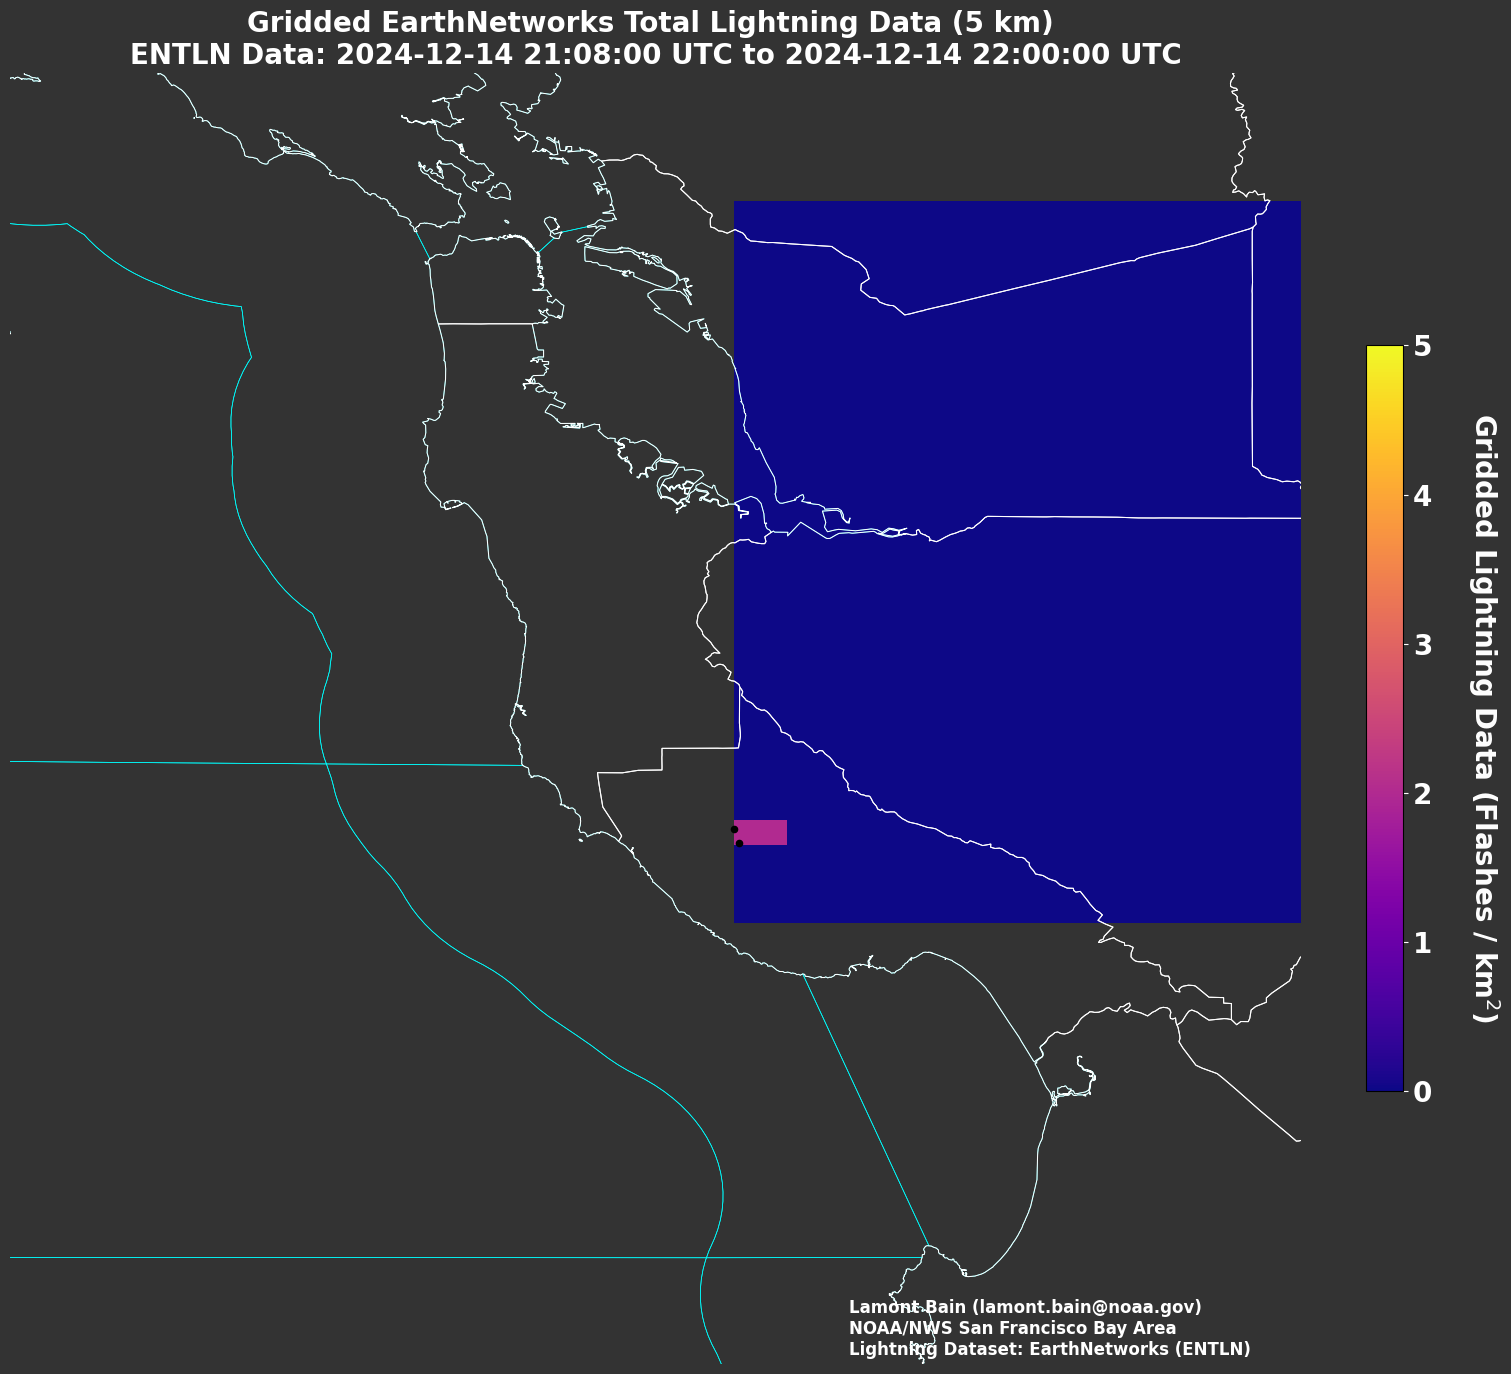

In [15]:
#@title 2-D Histogram
cwa = 'MTR'
#Box over MTR CWA
#lat_min, lat_max = 35.7, 39
#lon_min, lon_max = -124.5, -120

lon_min, lat_min, lon_max, lat_max = -123.0, 36.5, -121.5, 38.0
# Zoom out by expanding the bounding box
#lat_margin = 0.5  # Adjust this value to zoom out more or less
#lon_margin = 1.0  # Adjust this value to zoom out more or less

# Update the bounding box with expanded limits
#lat_min = lat_min - lat_margin
#lat_max = lat_max + lat_margin
#lon_min = lon_min - lon_margin
#lon_max = lon_max + lon_margin

# Define the number of bins for the histogram
print("Setting up bins for histogramming")
num_bins_x = len(x_grid) - 1
num_bins_y = len(y_grid) - 1

# Create a Plate Carrée projection
print("Setting up the projection....likely PlateCarree")
projection = ccrs.PlateCarree()

# Create a figure and axis with the desired settings
print("Setting up figures and axes")
fig, ax = plt.subplots(facecolor='#333333', figsize=(15, 15), edgecolor='black', constrained_layout=True,
                       subplot_kw={'projection': projection})

# Plot the 2D histogram as a heatmap
print("Creating 2D histogram for thematic map plot")
hist = ax.hist2d(lightning_df['longitude'], lightning_df['latitude'], bins=[num_bins_x, num_bins_y], cmap='plasma', vmin=0, vmax=5)

ax.scatter(lightning_df['longitude'], lightning_df['latitude'],
           transform=ccrs.PlateCarree(),  # Important: Specify the projection
           s=20,  # Adjust marker size as needed
           c='black',  # Adjust marker color as needed
           #alpha=0.5,  # Adjust marker transparency as needed
           zorder=10)  # Ensure points are plotted on top


# Add colorbar
print("Generating ColorBar")

cbar = plt.colorbar(hist[3], ax=ax, label='Gridded Lightning Data (Flashes / km$^2$)', ticklocation='right', shrink=0.5)
#cbar.set_clim(vmin=0, vmax=100)

cbar.set_label('Gridded Lightning Data (Flashes / km$^2$)', fontsize=20, color='white',
               fontweight='bold', rotation=270, labelpad=50)
cbar.ax.tick_params(colors='white', labelsize=20)

cbar.set_ticks(cbar.get_ticks())  # Use this line to fix the ticks
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontweight='bold')

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Gridded EarthNetworks Total Lightning Data ({grid_resolution_km} km) \nENTLN Data: {start_datetime} UTC to {end_datetime} UTC',
             fontsize=20, color='white', fontweight='bold')

# Set the extent to cover the Western United States
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add US state boundaries
#states = cfeature.NaturalEarthFeature(category='cultural', scale='10m',
#                                      facecolor='none', name='admin_1_states_provinces_lines')
#ax.add_feature(states, edgecolor='black', linewidth=4)

# Add US-Mexico border
border = cfeature.NaturalEarthFeature(category='cultural', scale='10m',
                                      facecolor='none', name='admin_0_boundary_lines_land')
ax.add_feature(border, edgecolor='black', linewidth=4)

# Add coastlines
#ax.coastlines(edgecolor='white', linewidth=4)

# Plot county boundaries
print("Loading and plotting county boundaries")
response = requests.get("https://www.weather.gov/source/gis/Shapefiles/County/c_08mr23.zip")
with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
    zip_ref.extractall("temp_folder")


# Read the shapefile
map_df = gpd.read_file("temp_folder/c_08mr23.shp")
county_map_df = map_df.query("STATE in ('CA', 'NV', 'OR', 'WA')")
ax.add_geometries(county_map_df['geometry'], crs=ccrs.PlateCarree(), edgecolor='white', facecolor='none', linewidth=0.75, zorder=3)

#Plot Marine Zones
# Plot county boundaries
#print("Loading and plotting marine boundaries")
response = requests.get("https://www.weather.gov/source/gis/Shapefiles/WSOM/mz05mr24.zip")
with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
    zip_ref.extractall("temp_folder")

marine_df = gpd.read_file("temp_folder/mz05mr24.shp")
marine_zone_df = marine_df.query(f"WFO in ('{cwa.upper()}')")
ax.add_geometries(marine_zone_df['geometry'], crs=ccrs.PlateCarree(), edgecolor='cyan', facecolor='none', linewidth=0.5, zorder=1)



# Add a watermark/signature
plt.annotate('Lamont Bain (lamont.bain@noaa.gov) \nNOAA/NWS San Francisco Bay Area \nLightning Dataset: EarthNetworks (ENTLN)', (0.65,0.05), (0, 0)
             , fontsize=12, xycoords='axes fraction', textcoords='offset points', va='top', color='white', fontweight='bold')

# Make a border around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_edgecolor('black')
ax.spines['left'].set_edgecolor('black')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.axis('off')

# Finalize and show the plot
print("Plotting and Saving the Map")
#plt.tight_layout()
#plt.savefig(f'/home/lamont.bain/output/img/{cwa}_grid_lightning.png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


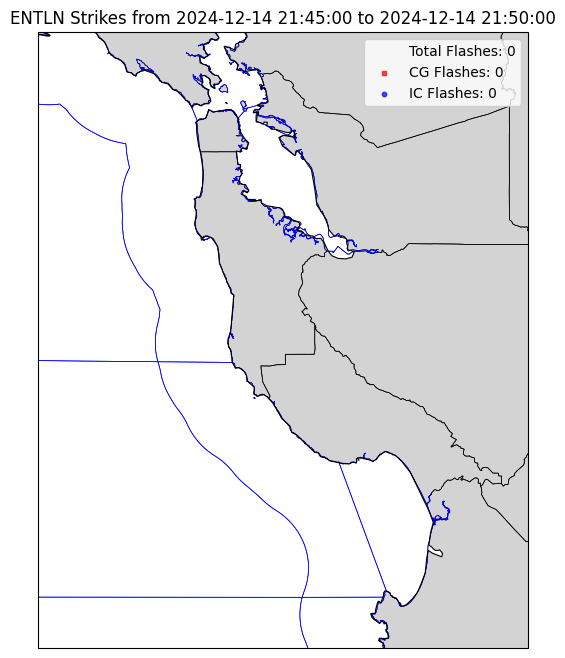

In [16]:
#@title Plot Mapped Timeseries with GIF animation

import matplotlib.animation as animation
import imageio

# Define lat/lon bounding box
lon_min, lat_min, lon_max, lat_max = -123.0, 36.5, -121.5, 38.0

# Define the time interval (5 minutes)
time_interval = pd.Timedelta(minutes=5)

# Group data into 5-minute intervals
grouped_data = lightning_df.groupby(pd.Grouper(key='ltg_time', freq=time_interval))

# CWA and shapefile paths
cwa = 'MTR'
county_shapefile_url = "https://www.weather.gov/source/gis/Shapefiles/County/c_08mr23.zip"
marine_shapefile_url = "https://www.weather.gov/source/gis/Shapefiles/WSOM/mz05mr24.zip"

# Function to download and extract shapefiles
def download_and_extract_shapefile(url, extract_path="temp_folder"):
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Download and extract shapefiles
download_and_extract_shapefile(county_shapefile_url)
download_and_extract_shapefile(marine_shapefile_url)

# Read shapefiles into GeoDataFrames
county_map_df = gpd.read_file("temp_folder/c_08mr23.shp").query("STATE in ('CA', 'NV', 'OR', 'WA')")
marine_zone_df = gpd.read_file("temp_folder/mz05mr24.shp").query(f"WFO in ('{cwa.upper()}')")

# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features (these will remain static)
ax.coastlines(resolution='10m', color='black', linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
county_map_df.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)
marine_zone_df.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=0.5)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Initialize scatter plots for CG and IC flashes (outside animate function)
cg_plot = ax.scatter([], [], transform=ccrs.PlateCarree(), s=10, c='red', marker='s', alpha=0.7)
ic_plot = ax.scatter([], [], transform=ccrs.PlateCarree(), s=10, c='blue', marker='o', alpha=0.7)

# Function to update the plot for each frame of the animation
def animate(i):
    name, group = list(grouped_data)[i]  # Get data for the current frame

    # Filter the group DataFrame
    filtered_group = group[
        (group['longitude'] >= lon_min) & (group['longitude'] <= lon_max) &
        (group['latitude'] >= lat_min) & (group['latitude'] <= lat_max)
    ]

    # Separate CG and IC flashes
    cg_flashes = filtered_group[filtered_group['type'] == 0]
    ic_flashes = filtered_group[filtered_group['type'] != 0]

    # Update data for scatter plots
    cg_plot.set_offsets(np.c_[cg_flashes['longitude'], cg_flashes['latitude']])
    ic_plot.set_offsets(np.c_[ic_flashes['longitude'], ic_flashes['latitude']])

    # Update labels for scatter plots
    cg_plot.set_label(f'CG Flashes: {len(cg_flashes)}')
    ic_plot.set_label(f'IC Flashes: {len(ic_flashes)}')

    # Update title
    ax.set_title(f"ENTLN Strikes from {name} to {name + time_interval}")

    # Update legend (include total flashes)
    total_flashes = len(cg_flashes) + len(ic_flashes)
    total_plot = ax.scatter([], [], s=0, label=f'Total Flashes: {total_flashes}')  # Invisible plot for total label
    ax.legend(handles=[total_plot, cg_plot, ic_plot],
              loc='upper right', fontsize=10, facecolor='white', framealpha=0.8)

    return cg_plot, ic_plot  # Return the artists for the animation


# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=len(grouped_data), interval=500, blit=False)

# Save the animation as a GIF
ani.save('lightning_strikes_animation.gif', writer='pillow')

plt.show()  # Display the final frame in the notebook

# 2D Histogram by Month

/tmp/ipykernel_8171/118581798.py:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=8.0)


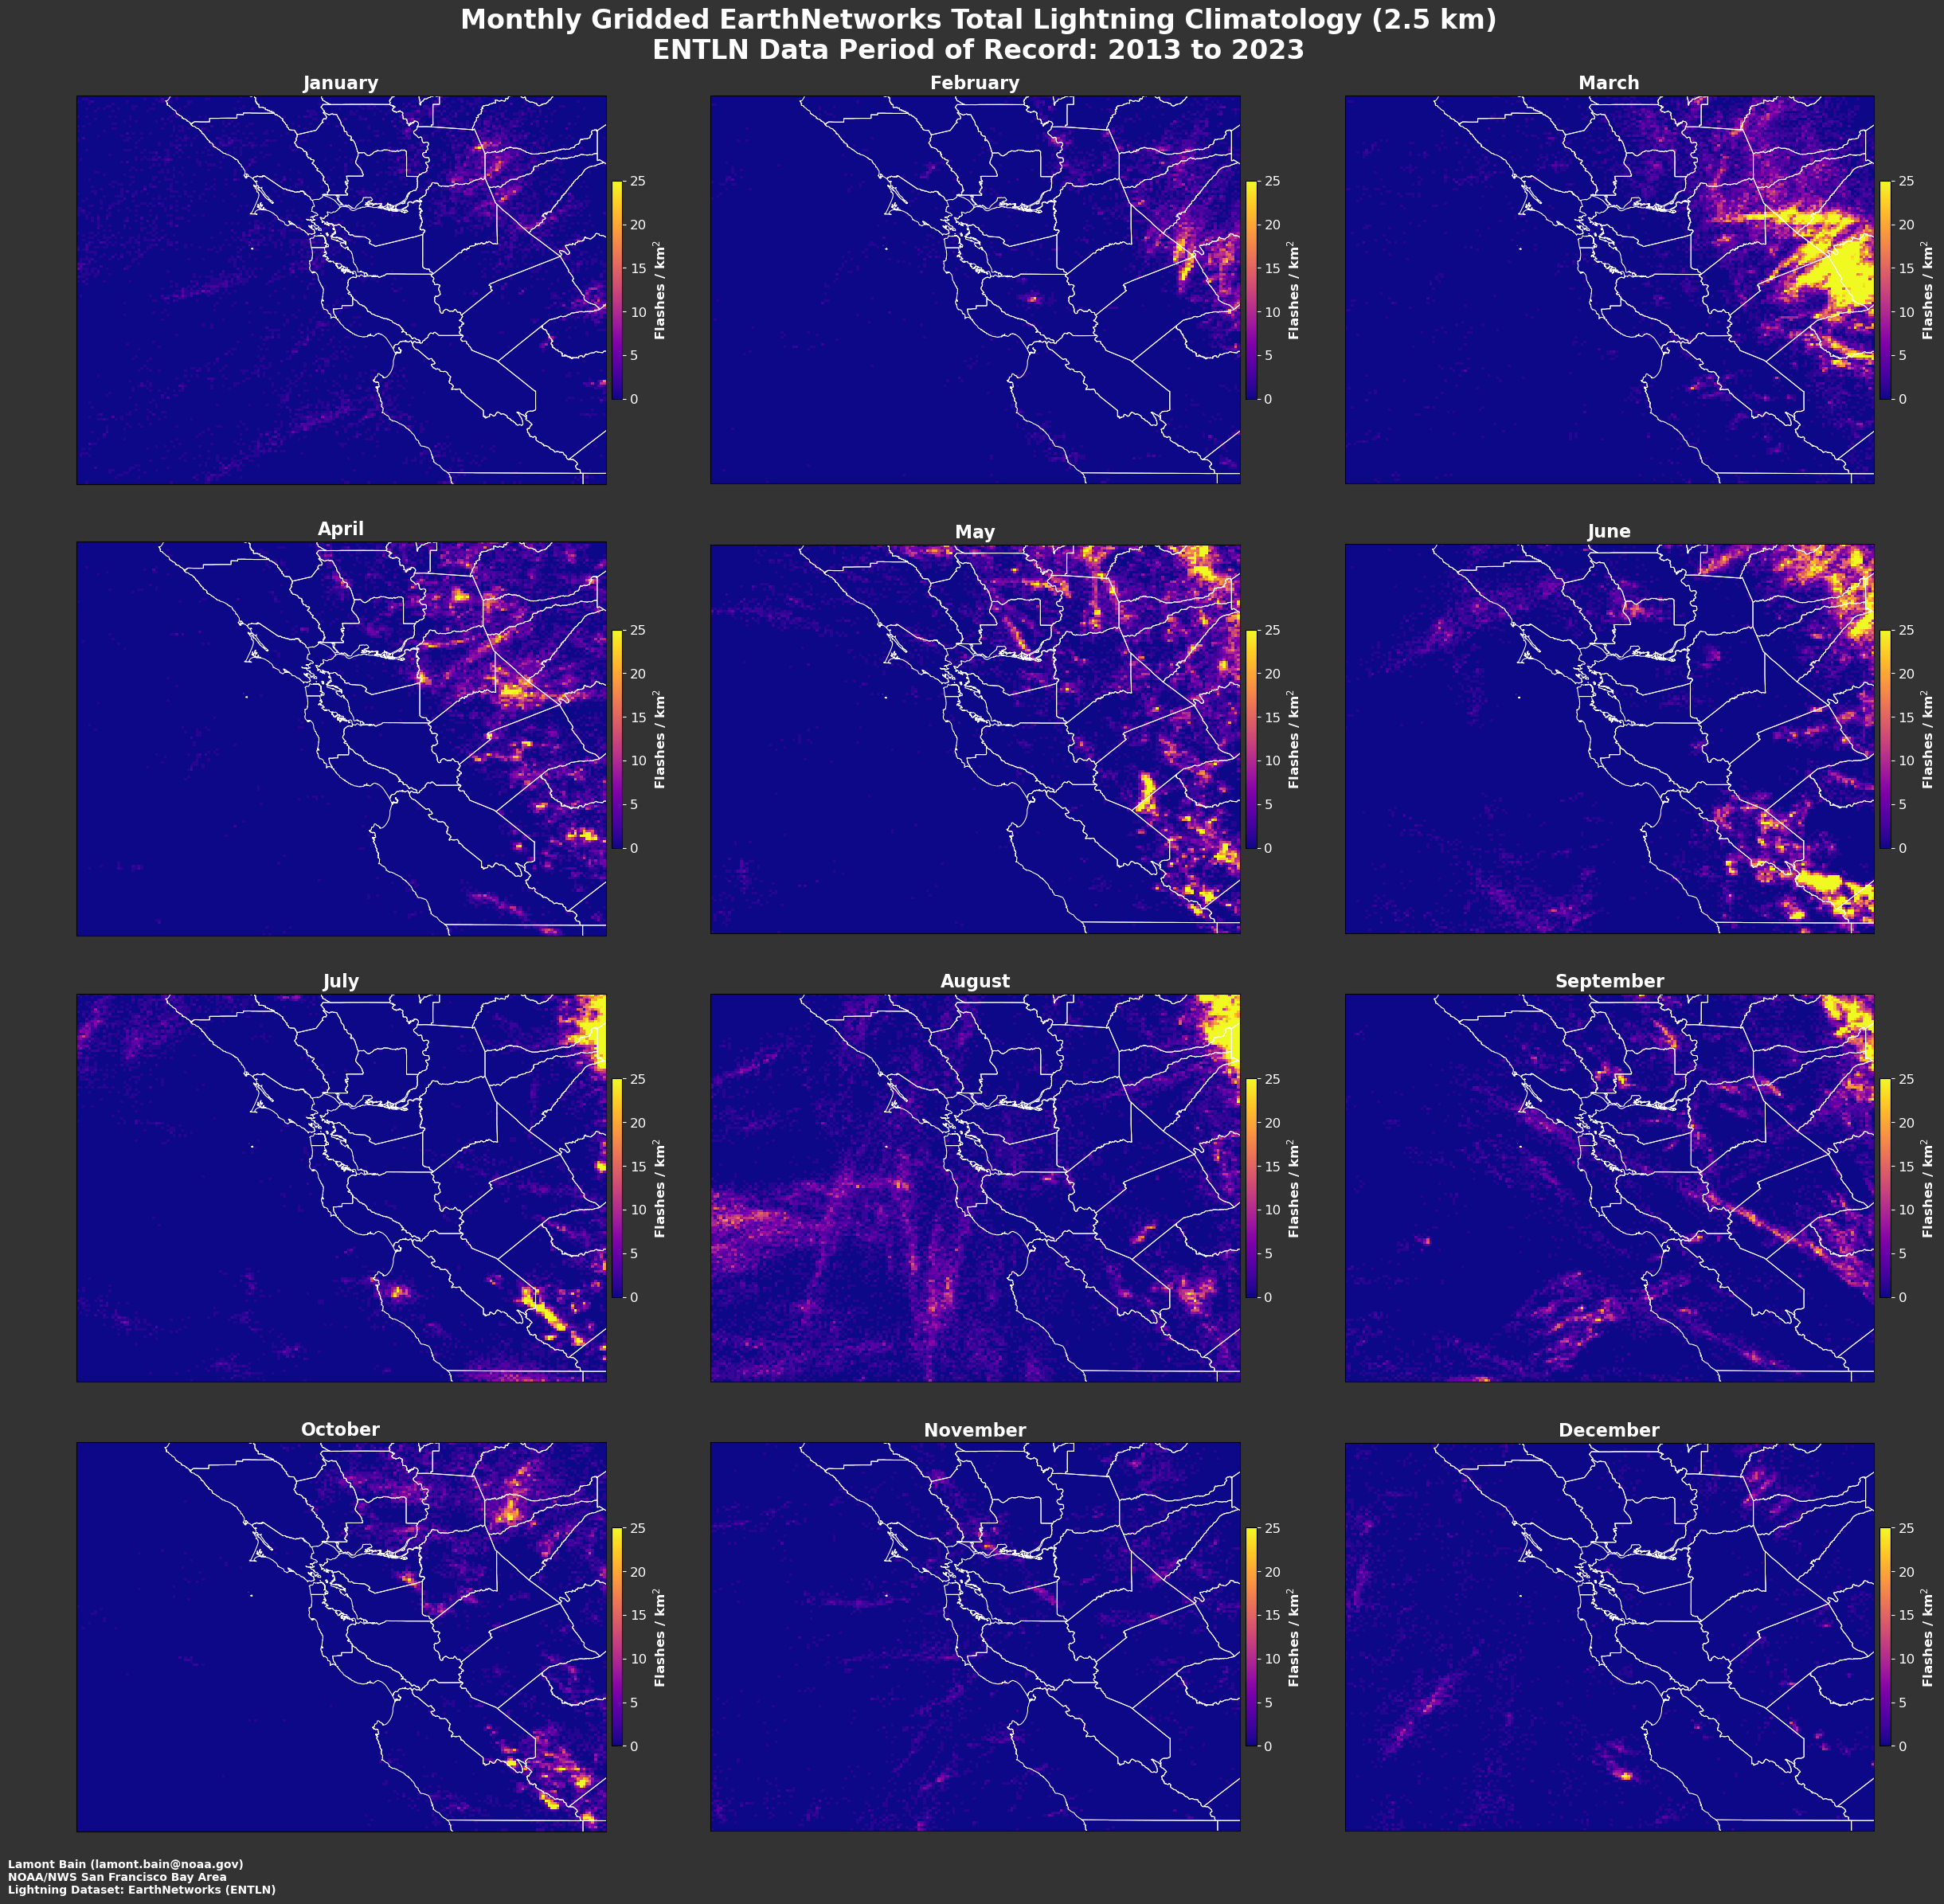

In [ ]:
import requests
import zipfile
import io
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

#expertimental color map
import colorcet as cc
from matplotlib.cm import get_cmap

# Define the bounding box over MTR CWA
lat_min, lat_max = 35.7, 39
lon_min, lon_max = -124.5, -120

# Create a Plate Carrée projection
projection = ccrs.PlateCarree()

# Create a 4x3 subplot (12 subplots for each month)
fig, axs = plt.subplots(4, 3, facecolor='#333333', figsize=(25, 25), edgecolor='black', constrained_layout=True,
                        subplot_kw={'projection': projection})

# Adjust layout to minimize blank space
fig.tight_layout(pad=8.0)
# Generate colorbar limits
vmin = 0
vmax = 25

cmin=2

# Load county boundaries (once, for all subplots)
response = requests.get("https://www.weather.gov/source/gis/Shapefiles/County/c_08mr23.zip")
with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
    zip_ref.extractall("temp_folder")

# Read the shapefile
map_df = gpd.read_file("temp_folder/c_08mr23.shp")
county_map_df = map_df.query("STATE in ('CA', 'NV', 'OR', 'WA')")

# Define month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Plot data for each month in a subplot
for i, ax in enumerate(axs.flat):
    month = i + 1  # Month index (1-12)

    # Filter data by month
    monthly_data = lightning_df[lightning_df['timestamp'].dt.month == month]

    # Set the extent to cover the Western United States
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Plot the 2D histogram as a heatmap for the given month
    num_bins_x = len(x_grid) - 1
    num_bins_y = len(y_grid) - 1
    hist = ax.hist2d(monthly_data['longitude'], monthly_data['latitude'], bins=[num_bins_x, num_bins_y],
                     cmap='plasma', vmin=vmin, vmax=vmax) #cmap=cc.cm.fire

    # Add county boundaries
    ax.add_geometries(county_map_df['geometry'], crs=ccrs.PlateCarree(), edgecolor='white', facecolor='none', linewidth=0.75)

    # Add the title for the current month
    ax.set_title(f'\n\n{month_names[month-1]}', fontsize=16, color='white', fontweight='bold')


    # Add rotated colorbar below each subplot
    cbar = plt.colorbar(hist[3], ax=ax, orientation='vertical', fraction=0.020, pad=0.01)
    cbar.set_label('Flashes / km$^2$', fontsize=12, color='white', fontweight='bold')
    cbar.ax.tick_params(colors='white', labelsize=12)
    #cbar.ax.xaxis.set_label_position('bottom')
    #cbar.ax.xaxis.set_ticks_position('bottom')


# Add a watermark/signature
fig.text(0.01, 0.05, 'Lamont Bain (lamont.bain@noaa.gov) \nNOAA/NWS San Francisco Bay Area \nLightning Dataset: EarthNetworks (ENTLN)'
         ,fontsize=10, va='top', color='white', fontweight='bold')


# Set the overall figure title
fig.suptitle(f'Monthly Gridded EarthNetworks Total Lightning Climatology ({grid_resolution_km} km) \nENTLN Data Period of Record: {first_year} to {last_year} \n', fontsize=24, color='white', fontweight='bold')



# Show the plot
#plt.tight_layout()
plt.savefig(f'/home/lamont.bain/output/img/{cwa}_gridded_km_grid_lightning_bymonth_.png', bbox_inches='tight')
plt.show()


# KDE Histograms for CWA Density Plots using PColorMesh

Setting up bins for histogramming
Setting up the projection....likely PlateCarree
Setting up figures and axes
Creating 2D histogram data for thematic map plot
Applying Gaussian smoothing
Loading and plotting county boundaries
Plotting and Saving the Map


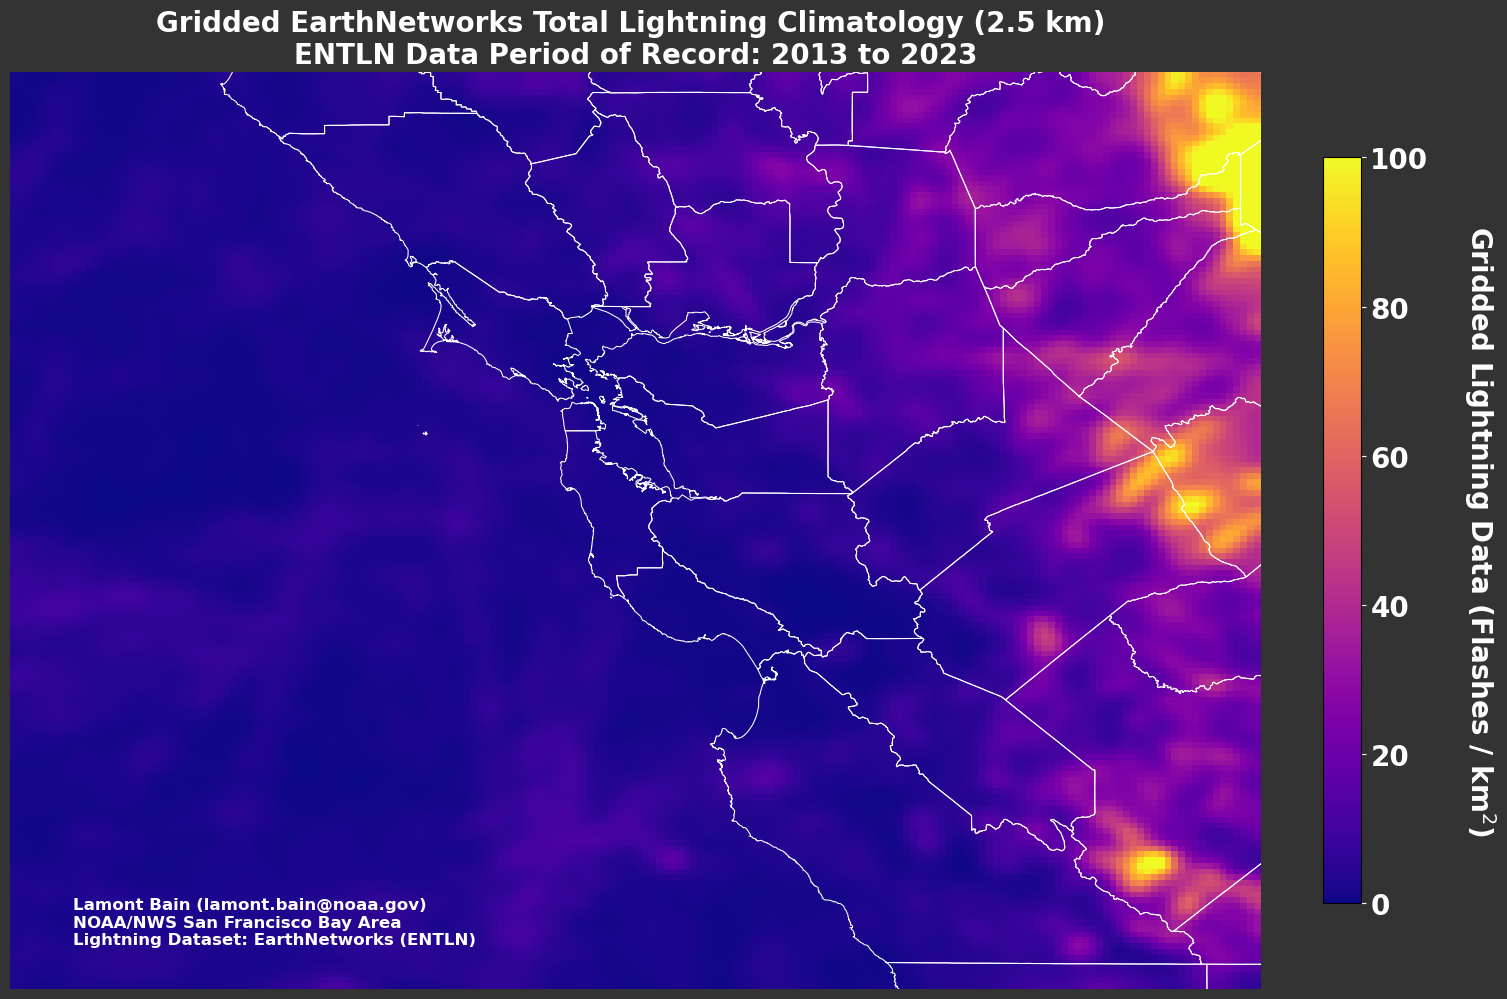

In [ ]:

### Import necessary libraries
import requests
import zipfile
import io
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter

#Box over MTR CWA
lat_min, lat_max = 35.7, 39
lon_min, lon_max = -124.5, -120

# Zoom out by expanding the bounding box
#lat_margin = 0.5  # Adjust this value to zoom out more or less
#lon_margin = 1.0  # Adjust this value to zoom out more or less

# Update the bounding box with expanded limits
#lat_min = lat_min - lat_margin
#lat_max = lat_max + lat_margin
#lon_min = lon_min - lon_margin
#lon_max = lon_max + lon_margin

# Define the number of bins for the histogram
print("Setting up bins for histogramming")
num_bins_x = len(x_grid) - 1
num_bins_y = len(y_grid) - 1

# Create a Plate Carrée projection
print("Setting up the projection....likely PlateCarree")
projection = ccrs.PlateCarree()

# Create a figure and axis with the desired settings
print("Setting up figures and axes")
fig, ax = plt.subplots(facecolor='#333333', figsize=(15, 15), edgecolor='black', constrained_layout=True,
                       subplot_kw={'projection': projection})

# Create the 2D histogram data manually
print("Creating 2D histogram data for thematic map plot")
counts, xedges, yedges = np.histogram2d(lightning_df['longitude'], lightning_df['latitude'], bins=[num_bins_x, num_bins_y])


# Apply Gaussian smoothing
print("Applying Gaussian smoothing")
sigma = 1.5  # Standard deviation for Gaussian kernel
smoothed_counts = gaussian_filter(counts.T, sigma=sigma)

# Define the x and y edges for pcolormesh
x, y = np.meshgrid(xedges, yedges)

# Plot with pcolormesh

c = ax.pcolormesh(x, y, smoothed_counts, cmap='plasma', vmin=0, vmax=100)

cbar = plt.colorbar(c, ax=ax, label='Gridded Lightning Data (Flashes / km$^2$)', ticklocation='right', shrink=0.5)
cbar.set_label('Gridded Lightning Data (Flashes / km$^2$)', fontsize=20, color='white',
               fontweight='bold', rotation=270, labelpad=50)

cbar.ax.tick_params(colors='white', labelsize=20)

cbar.set_ticks(cbar.get_ticks())  # Use this line to fix the ticks
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontweight='bold')

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Gridded EarthNetworks Total Lightning Climatology ({grid_resolution_km} km) \nENTLN Data Period of Record: {first_year} to {last_year}', fontsize=20, color='white', fontweight='bold')

# Set the extent to cover the Western United States
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())


border = cfeature.NaturalEarthFeature(category='cultural', scale='10m',
                                      facecolor='none', name='admin_0_boundary_lines_land')
ax.add_feature(border, edgecolor='black', linewidth=4)



# Plot county boundaries
print("Loading and plotting county boundaries")
response = requests.get("https://www.weather.gov/source/gis/Shapefiles/County/c_08mr23.zip")
with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
    zip_ref.extractall("temp_folder")


# Read the shapefile
map_df = gpd.read_file("temp_folder/c_08mr23.shp")
county_map_df = map_df.query("STATE in ('CA', 'NV', 'OR', 'WA')")
ax.add_geometries(county_map_df['geometry'], crs=ccrs.PlateCarree(), edgecolor='white', facecolor='none', linewidth=0.75)

#Plot Marine Zones
# Plot county boundaries
#print("Loading and plotting marine boundaries")
#response = requests.get("https://www.weather.gov/source/gis/Shapefiles/WSOM/mz05mr24.zip")
#with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
#    zip_ref.extractall("temp_folder")

#marine_df = gpd.read_file("temp_folder/mz05mr24.shp")
#marine_zone_df = marine_df.query(f"WFO in ('{cwa.upper()}')")
#ax.add_geometries(marine_zone_df['geometry'], crs=ccrs.PlateCarree(), edgecolor='cyan', facecolor='none', linewidth=0.5)



# Add a watermark/signature
plt.annotate('Lamont Bain (lamont.bain@noaa.gov) \nNOAA/NWS San Francisco Bay Area \nLightning Dataset: EarthNetworks (ENTLN)', (0.05,0.1), (0, 0)
             , fontsize=12, xycoords='axes fraction', textcoords='offset points', va='top', color='white', fontweight='bold')

# Make a border around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_edgecolor('black')
ax.spines['left'].set_edgecolor('black')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.axis('off')

# Finalize and show the plot
print("Plotting and Saving the Map")
#plt.tight_layout()
#plt.savefig(f'/home/lamont.bain/output/img/{cwa}_grid_lightning.png', bbox_inches='tight')
plt.show()

# KDE Histograms for CWA Density Plots by month using PColorMesh

/tmp/ipykernel_8171/81574134.py:33: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.25, wspace=0.25)
/tmp/ipykernel_8171/81574134.py:36: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=8.0)


<Figure size 640x480 with 0 Axes>

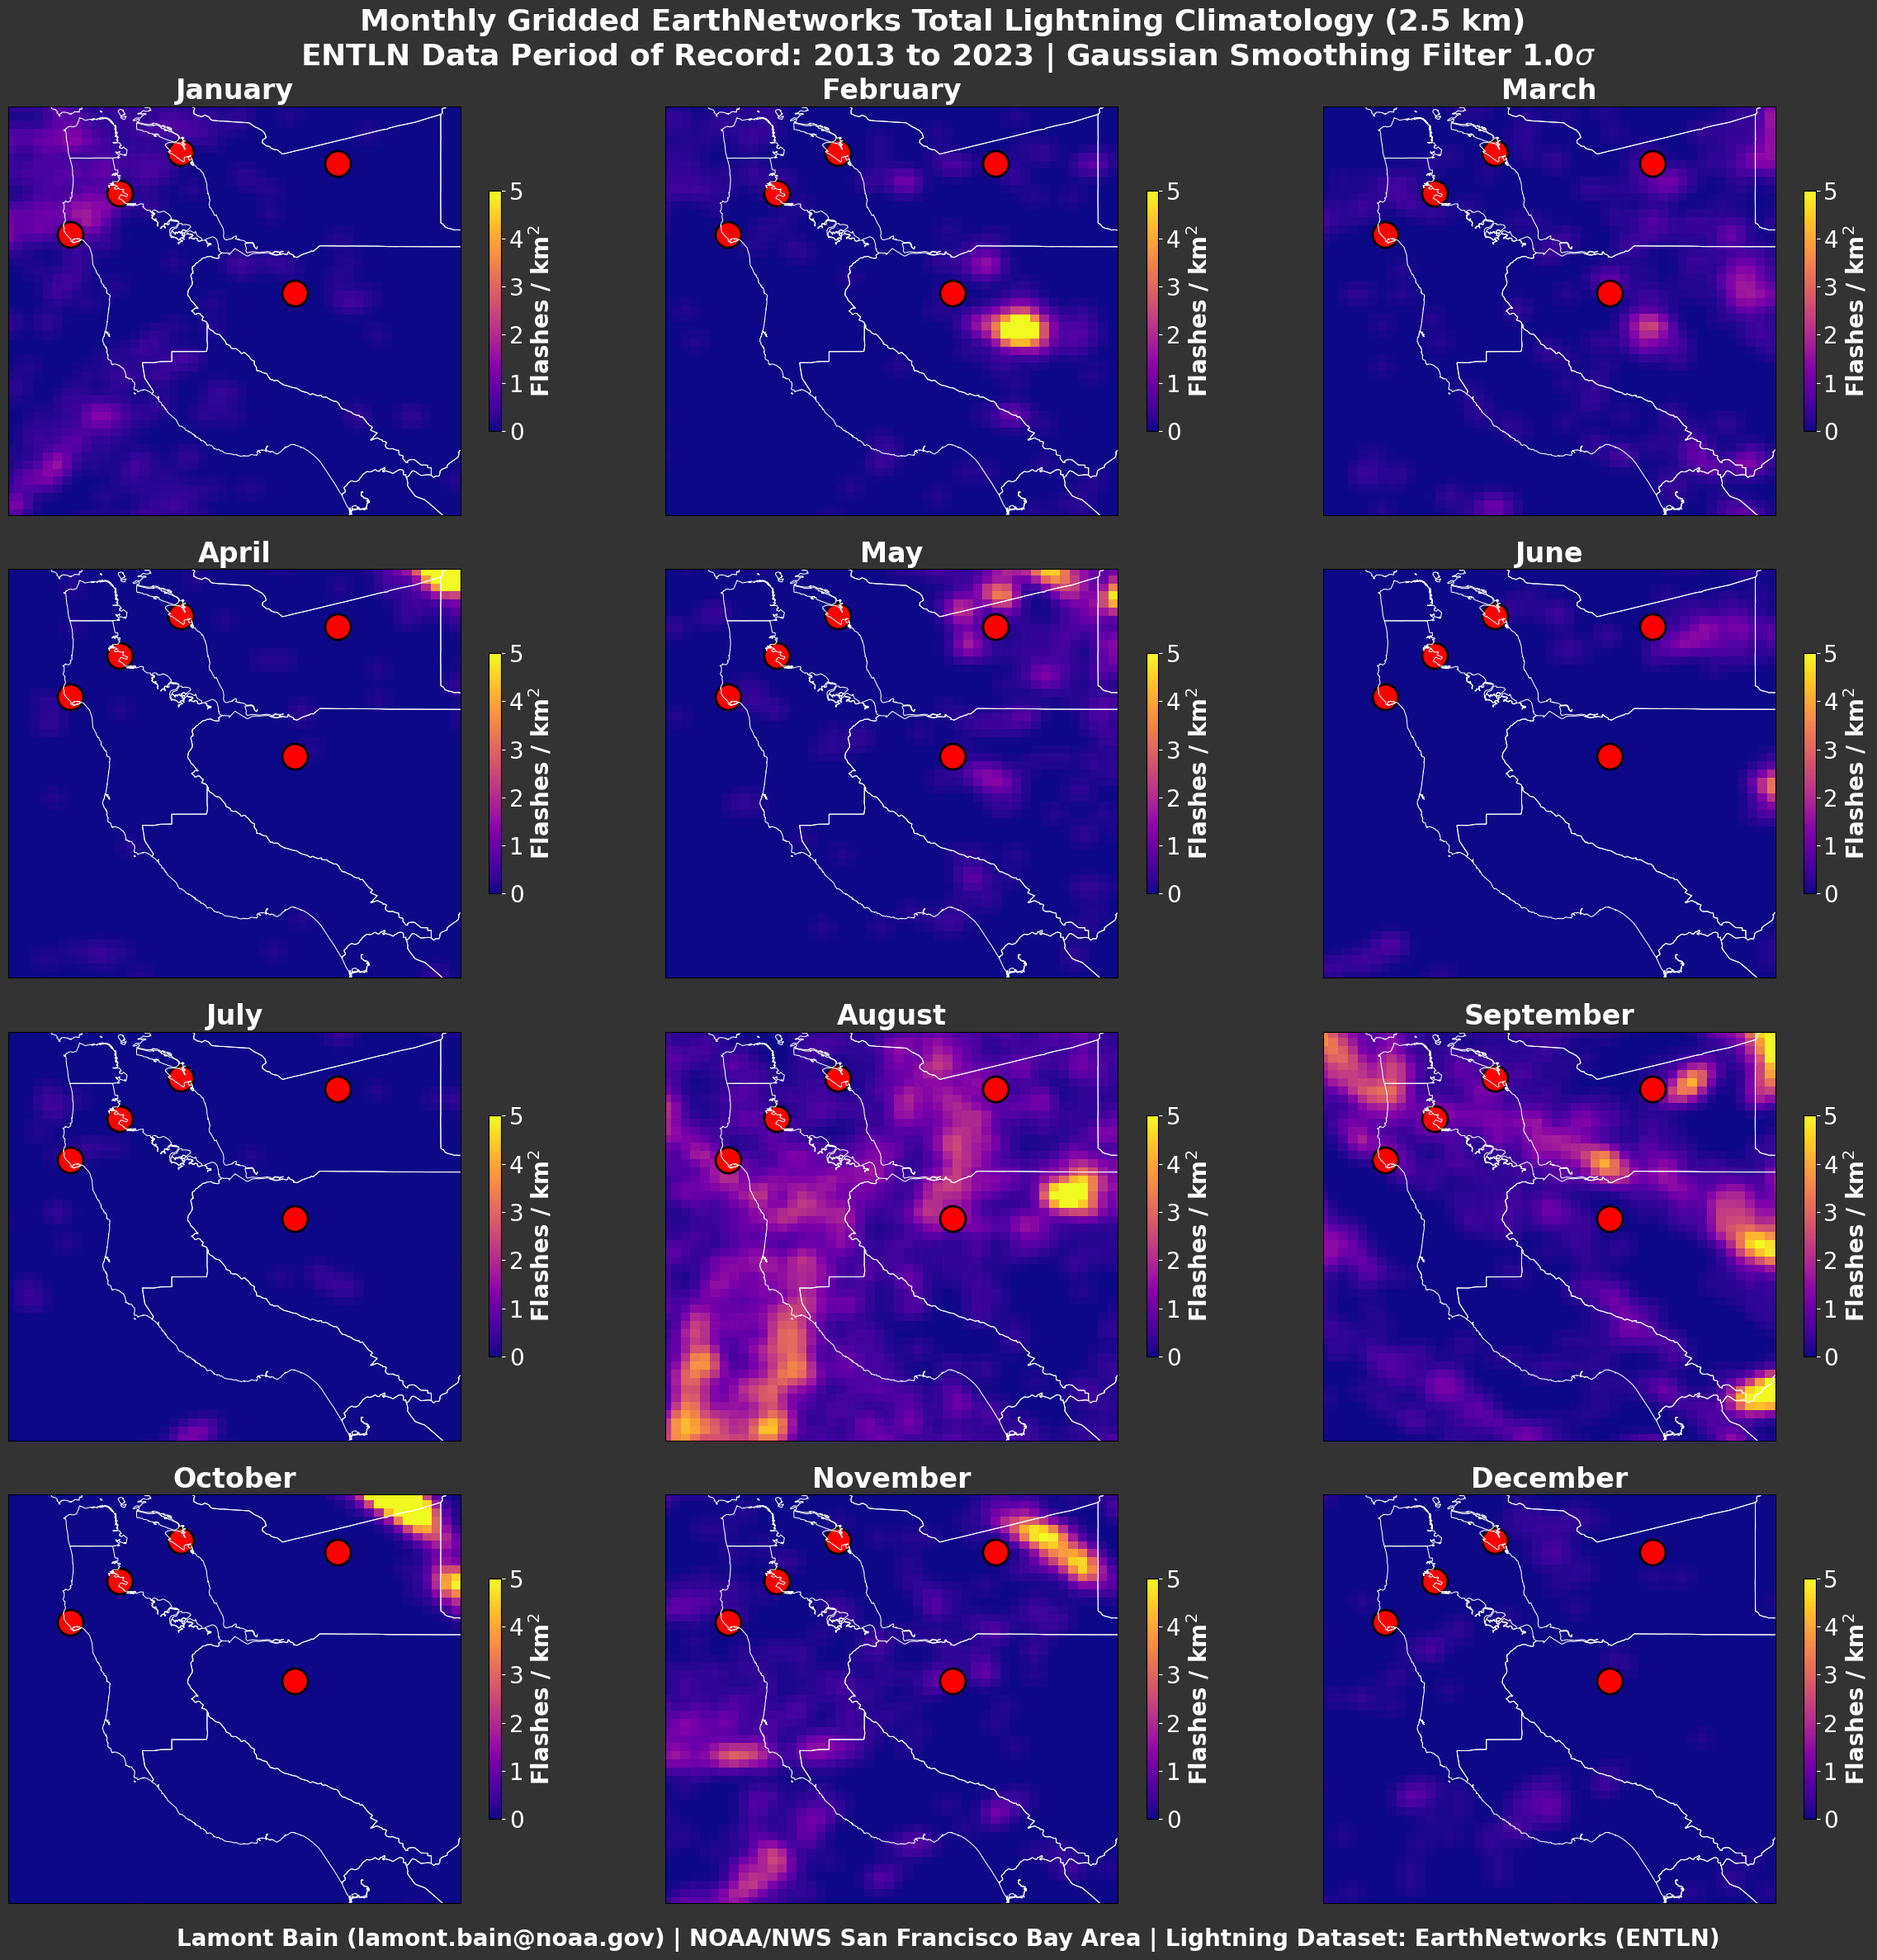

In [ ]:
import requests
import zipfile
import io
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from shapely.geometry import Point
from scipy.ndimage import gaussian_filter

#expertimental color map
import colorcet as cc
from matplotlib.cm import get_cmap

# Define the bounding box over MTR CWA
#lat_min, lat_max = 35.7, 39
#lon_min, lon_max = -124, -120


#Bay Area Zoom
lon_min, lat_min, lon_max, lat_max = -122.659607,36.798289,-121.506042,37.840157

# Create a Plate Carrée projection
projection = ccrs.PlateCarree()

# Create a 4x3 subplot (12 subplots for each month)
plt.clf()
fig, axs = plt.subplots(4, 3, facecolor='#333333', figsize=(25, 25), edgecolor='black', constrained_layout=True,
                        subplot_kw={'projection': projection})

# Adjust the space between subplots
plt.subplots_adjust(hspace=0.25, wspace=0.25)

# Adjust layout to minimize blank space
fig.tight_layout(pad=8.0)

# Load county boundaries (once, for all subplots)
response = requests.get("https://www.weather.gov/source/gis/Shapefiles/County/c_08mr23.zip")
with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
    zip_ref.extractall("temp_folder")

# Read the shapefile
map_df = gpd.read_file("temp_folder/c_08mr23.shp")
county_map_df = map_df.query("STATE in ('CA', 'NV', 'OR', 'WA')")

# Define month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Plot data for each month in a subplot
for i, ax in enumerate(axs.flat):
    month = i + 1  # Month index (1-12)

    # Filter data by month
    monthly_data = lightning_df[lightning_df['timestamp'].dt.month == month]

    # Set the extent to cover the Western United States
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Plot the 2D histogram as a heatmap for the given month
    num_bins_x = len(x_grid) - 1
    num_bins_y = len(y_grid) - 1
    #hist = ax.hist2d(monthly_data['longitude'], monthly_data['latitude'], bins=[num_bins_x, num_bins_y],
                     #cmap='plasma', vmin=vmin, vmax=vmax) #cmap=cc.cm.fire


    # Create the 2D histogram data manually
    #print("Creating 2D histogram data for thematic map plot")
    counts, xedges, yedges = np.histogram2d(monthly_data['longitude'], monthly_data['latitude'], bins=[num_bins_x, num_bins_y])

    # Apply Gaussian smoothing
    #print("Applying Gaussian smoothing")
    sigma = 1.0  # Standard deviation for Gaussian kernel
    smoothed_counts = gaussian_filter(counts.T, sigma=sigma)

    # Define the x and y edges for pcolormesh
    x, y = np.meshgrid(xedges, yedges)
    c = ax.pcolormesh(x, y, smoothed_counts, cmap='plasma', vmin=0, vmax=5)


    # Add county boundaries
    ax.add_geometries(county_map_df['geometry'], crs=ccrs.PlateCarree(), edgecolor='white', facecolor='none', linewidth=0.75)

    # Add specific cities
    # Step 1: Define the airport ICAO codes and their coordinates
    airport_data = {
        'KHAF': (37.5134, -122.5011),  # Half Moon Bay
        'KSFO': (37.6188, -122.3754),  # San Francisco International
        'KSJC': (37.3639, -121.9289),  # San Jose International
        'KOAK': (37.7213, -122.2207),  # Oakland International
        'KLVK': (37.6939, -121.8193)   # Livermore Municipal
    }

    # Step 2: Create a GeoDataFrame with the locations
    gdf = gpd.GeoDataFrame(
        list(airport_data.items()),
        columns=['ICAO', 'Coordinates'],
        geometry=[Point(lon, lat) for lat, lon in airport_data.values()]
    )



    # Step 4: Plot the airport locations and labels
    gdf.plot(ax=ax, color='red', markersize=500, lw=2.0, edgecolor='black')


    ax.set_title(f'{month_names[month-1]}', fontsize=24, color='white', fontweight='bold')


    # Add rotated colorbar below each subplot
    cbar = plt.colorbar(c, ax=ax, label='Gridded Lightning Data (Flashes / km$^2$)', ticklocation='right', shrink=0.5)
    cbar.set_label('Flashes / km$^2$', fontsize=20, color='white', fontweight='bold')
    cbar.ax.tick_params(colors='white', labelsize=20)
    #cbar.ax.xaxis.set_label_position('bottom')
    #cbar.ax.xaxis.set_ticks_position('bottom')


# Add a watermark/signature
fig.text(0.50, 0.05, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area | Lightning Dataset: EarthNetworks (ENTLN)'
         ,fontsize=20, va='top', ha='center', color='white', fontweight='bold')

#Adjust the position of the subplots
plt.subplots_adjust(top=0.95)

# Set the overall figure title
fig.suptitle(f'Monthly Gridded EarthNetworks Total Lightning Climatology ({grid_resolution_km} km) \nENTLN Data Period of Record: {first_year} to {last_year} | Gaussian Smoothing Filter {sigma}$\\sigma$ ', fontsize=26, color='white', fontweight='bold')



# Show the plot
#plt.tight_layout()
plt.savefig(f'/home/lamont.bain/output/img/{cwa}_gridded_km_grid_lightning_bymonth_bayarea.png', bbox_inches='tight')
plt.show()
